In [1]:
from fbprophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

In [34]:
import sys
from yahoo_finance_api2 import share
from yahoo_finance_api2.exceptions import YahooFinanceError

bitcoin_aud = share.Share('BTC-AUD')
bitcoin_data = bitcoin_aud.get_historical(
    share.PERIOD_TYPE_DAY, 7,
    share.FREQUENCY_TYPE_MINUTE, 1)

In [35]:
# bitcoin_data

In [36]:
df = pd.DataFrame(bitcoin_data)
df.head()
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ms')

In [39]:
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ms')
(df.set_index("timestamp")
   .resample('5Min')
   .mean()
)

,open,high,low,close,volume
timestamp,,,,,
2020-05-23 05:35:00,14182.522461,14182.658203,14182.522461,14182.658203,0.000000e+00
2020-05-23 05:40:00,14186.082031,14187.177246,14186.082031,14187.177246,3.125842e+08
2020-05-23 05:45:00,14188.098633,14190.075521,14188.098633,14190.075521,0.000000e+00
2020-05-23 05:50:00,14192.815430,14192.965495,14192.249023,14192.399089,0.000000e+00
2020-05-23 05:55:00,14193.776693,14193.776693,14193.533529,14193.533529,2.550443e+06
...,...,...,...,...,...
2020-05-30 05:15:00,14228.069661,14228.069661,14227.069987,14227.069987,1.956523e+06
2020-05-30 05:20:00,14224.968424,14225.688802,14224.968424,14225.688802,2.030251e+06
2020-05-30 05:25:00,14227.956299,14228.794434,14227.956299,14228.794434,1.637683e+07


In [80]:
class Features:
    def impute_missing(self, data):
        return data.fillna(method='ffill')

    def average_true_range(self, data):
        atr_list = []
        for i, row in data.iterrows():
            close = row['close']
            high = row['high']
            low = row['close']

            if not i:
                atr_list.append(None)
            else:
                v1 = abs(close - low)
                v2 = abs(high - close_p)
                v3 = abs(low - close_p)
                
                atr = max(v1, v2, v3)
                atr_list.append(atr)

            close_p = close
            high_p = high
            low_p = low
        data['tr'] = atr_list
        data['average_true_range'] = data['tr'].rolling(window=10).mean()
        return data

    def moving_average_cp(self, data):
        data['moving_average_close'] = data['close'].rolling(window=10).mean()
        return data

    def moving_average_volume(self, data):
        data['moving_average_volume'] = data['volume'].rolling(window=10).mean()
        return data

    def select(self, data):
        cols = [
            'close', 'moving_average_volume',
            'moving_average_close','average_true_range'
        ]
        return data[cols]

    def _pipeline(self, data):
        final = (
            data.pipe(self.impute_missing)
            .pipe(self.average_true_range)
            .pipe(self.moving_average_cp)
            .pipe(self.moving_average_volume)
            .pipe(self.select)
        )
        return final.iloc[10:, :]
    
    @classmethod
    def pipeline(cls, data):
        return cls()._pipeline(data)

Features.pipeline(df)

,close,moving_average_volume,moving_average_close,average_true_range
10,14192.684570,125033676.8,14187.913574,1.072754
11,14194.716797,125033676.8,14189.119434,1.275977
12,14194.716797,125033676.8,14189.875391,0.826074
13,14192.435547,125033676.8,14190.403223,1.054199
14,14192.435547,62516838.4,14190.927051,1.050195
...,...,...,...,...
10066,14228.559570,8147353.6,14228.179199,0.788965
10067,14228.559570,8147353.6,14228.292969,0.787988
10068,14227.369141,10246553.6,14228.287695,0.907031
10069,14227.026367,6198886.4,14228.038965,0.732129


In [5]:
data = df.rename(columns={'timestamp': 'ds', 'open': 'y'})

In [6]:
m = Prophet( yearly_seasonality=False, weekly_seasonality=False)
m.fit(data[['ds','y']])

In [7]:
future = m.make_future_dataframe(periods=1)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2878,2020-05-30 05:10:00,14214.654481,14113.367909,14325.829202
2879,2020-05-30 05:15:00,14215.184094,14110.268047,14319.137355
2880,2020-05-30 05:20:00,14215.765607,14114.110249,14330.905168
2881,2020-05-30 05:20:01,14215.767629,14111.843786,14319.989301
2882,2020-05-31 05:20:01,14297.637837,13242.701657,15285.269986


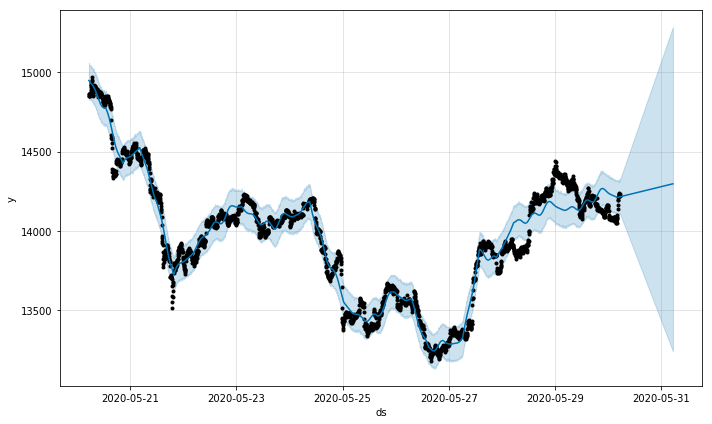

In [8]:
fig1 = m.plot(forecast)
plt.show()

In [10]:
# import panda, keras and tensorflow
import pandas as pd
import tensorflow as tf
import keras
from keras import models, layers
# Load the sample data set and split into x and y data frames 
df = pd.read_csv("game.csv")
x = df.drop(['label'], axis=1)
y = df['label']
# Define the keras model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10,)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Use a custom metricfunction
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    keras.backend.get_session().run(tf.local_variables_initializer())
    return auc    
# Compile and fit the model
model.compile(optimizer='rmsprop',loss='binary_crossentropy',
              metrics=[auc])
history = model.fit(x, y, epochs=100, batch_size=100,
                    validation_split = .2, verbose=0)
# Save the model in h5 format 
model.save("games.h5")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing 

KeyboardInterrupt: 

In [ ]:
!curl -0 https://raw.githubusercontent.com/bgweber/Twitch/master/Recommendations/games-expand.csv

In [3]:
!ls

Trade-Bot.ipynb game.csv
